In [1]:
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback
from tensorflow.keras import metrics,optimizers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import classification_report

In [3]:
#Setting up images path
# Linux path
PATH = "/home/changsmarter/Desktop/myAI_Project/10000_PHASE1/"
SELECTED_CLASS = "10000_NoF_Class.csv"
SELECTED_LABEL = "Is No_Finding"
SUB = 'temp'
LABEL="NoF_fix2_"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob(SUB+'/*/*/*.jpg')))
image_csv = pd.read_csv(PATH+SELECTED_CLASS)
CLASS_NAME = image_csv[SELECTED_LABEL].unique()
# Check number of TRUE file and all file count        
print(image_num)
print(CLASS_NAME)

10000
['No' 'Yes']


In [4]:
##loading image from given path
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + SUB + "/train/"
VALID_PATH = PATH + SUB + "/valid/"
TEST_PATH = PATH + SUB + "/test/"
#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  color_mode='rgb')
#This will be my valid_set . 
data_gen_valid = my_generator.flow_from_directory(directory=VALID_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 color_mode='rgb')
#This will be my test_set . 
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 color_mode='rgb')
x_train,y_train = next(data_gen_train)
x_valid,y_valid = next(data_gen_valid)
x_test,y_test = next(data_gen_test)

Found 8001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [88]:
#Load pre-trained InceptionV3 MODEL
myInception = tf.keras.applications.InceptionV3(include_top=False,
                                                input_shape=(224,224,3)
                                                ,weights='imagenet')
for layer in myInception.layers:
    layer.trainable=False

out = myInception.output
out = layers.GlobalMaxPooling2D()(out)
out = layers.Dense(1024,activation='relu')(out)
out = layers.Dropout(0.5)(out)
out = layers.Dense(512,activation='relu')(out)
out = layers.Dropout(0.5)(out)
out = layers.Dense(256,activation='relu')(out)
out = layers.Dropout(0.5)(out)
out = layers.Dense(128,activation='relu')(out)
out = layers.Dropout(0.3)(out)
out = layers.Dense(2,activation='softmax')(out)

myModel=Model(myInception.input,out)
for layer in myModel.layers[155:]:
    layer.trainable=True

In [89]:
myModel.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1222 (Conv2D)            (None, 111, 111, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1226 (Batch (None, 111, 111, 32) 96          conv2d_1222[0][0]                
__________________________________________________________________________________________________
activation_1222 (Activation)    (None, 111, 111, 32) 0           batch_normalization_1226[0][0]   
____________________________________________________________________________________________

In [98]:
## Setting up callback function for detecting training status
myEarly = EarlyStopping(monitor='val_loss',patience=5,verbose=1)
myCheckpoint = ModelCheckpoint('Model2/'+LABEL+'IncpV3.hdf5',
                               monitor='val_loss',
                              save_best_only=True)
#Callback function when my model hit my max ACC
class mystopclass(Callback):
    def on_epoch_end(self,epoch,log={}):
        if(log.get('accuracy') > 0.999 or log.get('loss') < 0.001):
            print("\n\nReached my Destination. Stoppped Training!!\n\n")
            self.model.stop_training = True
myStop = mystopclass()

In [99]:
myModel.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(lr=1e-4,decay=1e-6)
                ,metrics=['accuracy'])

In [100]:
TRAIN_IMG = 8000
TEST_IMG = 1000
VALID_IMG = 1000

In [101]:
#Training myModel
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
STEP_PER_EPOCH = np.ceil(TRAIN_IMG/BATCH_SIZE)
VALID_STEP = np.ceil(VALID_IMG/BATCH_SIZE)
mySession = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_valid,
                               epochs = 20,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = VALID_STEP,
                               verbose = 1,
                               callbacks=[myEarly,myCheckpoint,myStop])
myModel.save('Model2/'+LABEL+'Incep3_done.h5')

Train for 250.0 steps, validate for 32.0 steps
Epoch 1/20
250/250 [==============================] - 47s 190ms/step - loss: 0.0646 - accuracy: 0.9768 - val_loss: 1.5546 - val_accuracy: 0.8340
Epoch 2/20
250/250 [==============================] - 40s 159ms/step - loss: 0.0321 - accuracy: 0.9902 - val_loss: 1.5268 - val_accuracy: 0.8390
Epoch 3/20
250/250 [==============================] - 39s 156ms/step - loss: 0.0454 - accuracy: 0.9853 - val_loss: 1.4114 - val_accuracy: 0.8360
Epoch 4/20
250/250 [==============================] - 39s 155ms/step - loss: 0.0339 - accuracy: 0.9893 - val_loss: 1.0423 - val_accuracy: 0.8420
Epoch 5/20
250/250 [==============================] - 38s 152ms/step - loss: 0.0272 - accuracy: 0.9910 - val_loss: 1.5393 - val_accuracy: 0.8440
Epoch 6/20
250/250 [==============================] - 38s 152ms/step - loss: 0.0227 - accuracy: 0.9937 - val_loss: 2.2060 - val_accuracy: 0.8350
Epoch 7/20
250/250 [==============================] - 38s 152ms/step - loss: 0.0332

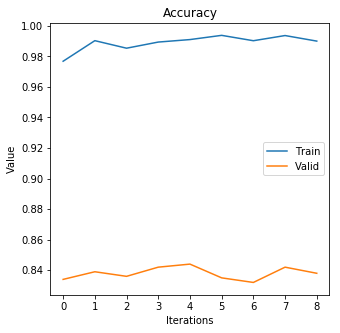

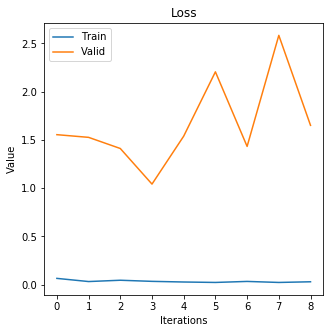

In [102]:
plt.figure(figsize=(5,5))
plt.plot(mySession.history['accuracy'])
plt.plot(mySession.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig('Run_Result2/'+LABEL+"InceptV3_Acc.png")
plt.show()
plt.figure(figsize=(5,5))
plt.plot(mySession.history['loss'])
plt.plot(mySession.history['val_loss'])
plt.title('Loss')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig('Run_Result2/'+LABEL+"InceptV3_Loss.png")
plt.show()

In [103]:
y_pred = myModel.predict_generator(data_gen_test)
pred = np.argmax(y_pred,axis=1)
print(classification_report(data_gen_test.classes,pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       844
           1       0.24      0.03      0.05       156

    accuracy                           0.83      1000
   macro avg       0.54      0.51      0.48      1000
weighted avg       0.75      0.83      0.77      1000



In [104]:
from sklearn.metrics import confusion_matrix
confusion_matrix(data_gen_test.classes,pred)

array([[831,  13],
       [152,   4]])

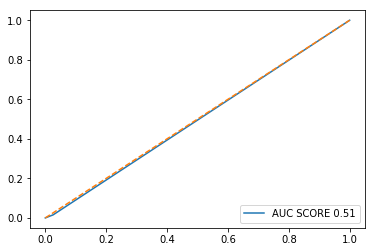

In [105]:
auc = roc_auc_score(data_gen_test.classes,pred)
tpr,fpr,_ = roc_curve(data_gen_test.classes,pred)
plt.plot(fpr,tpr,label="AUC SCORE %0.2f"%auc)
plt.plot([0,1],[0,1],linestyle='--')
plt.legend(loc='lower right')
plt.show()